# MNIST dataset을 JPG 파일로 변환

Convert the original MNIST dataset into JPG format

the original MNIST dataset: https://www.kaggle.com/datasets/hojjatk/mnist-dataset


Convertor: https://github.com/teavanist/MNIST-JPG



In [1]:
import os
import struct
import sys
import numpy

from array import array
from os import path
from PIL import Image #imported from pillow
import csv
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

# funtion to read the MNIST dataset

def read(dataset):
    if dataset == "training":

        fname_img = "/content/train-images.idx3-ubyte"
        fname_lbl = "/content/train-labels.idx1-ubyte"

    elif dataset == "testing":

        fname_img = "/content/t10k-images.idx3-ubyte"
        fname_lbl = "/content/t10k-labels.idx1-ubyte"

    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    return lbl, img, size, rows, cols

# funtion to extract and  the MNIST dataset
def write_dataset(dataset,labels, data, size, rows, cols, output_dir):

    output_dirs = [
        path.join(output_dir, str(i))
        for i in range(10)
    ]
    for dir in output_dirs:
        if not path.exists(dir):
            os.makedirs(dir)

    csv_file_name = path.join(output_dir, dataset+'.csv')
    csv_f = open(csv_file_name,'w', newline='')
    wr = csv.writer(csv_f)
    wr.writerow(['path','label'])

    # write data
    for (i, label) in tqdm(enumerate(labels)):
        output_filename = path.join(output_dirs[label], str(i) + ".jpg")
        #print("writing " + output_filename)
        wr.writerow([str(label)+"/"+str(i) + ".jpg",label])
        with open(output_filename, "wb") as h:
            data_i = [
                data[ (i*rows*cols + j*cols) : (i*rows*cols + (j+1)*cols) ]
                for j in range(rows)
            ]
            data_array = numpy.asarray(data_i)


            im = Image.fromarray(data_array)
            im.save(output_filename)

    csv_f.close()
output_path = '/content/mnist_jpg'

for dataset in ["training", "testing"]:
    labels, data, size, rows, cols = read(dataset)
    write_dataset(dataset,labels, data, size, rows, cols,
                  path.join(output_path, dataset))

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
# 생성된 MNIST jpg 파일을 하나의 파일로 압축
!zip -r /content/MNIST_jpg.zip /content/mnist_jpg

In [ ]:
from google.colab import files
files.download("/content/MNIST_jpg.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# MNIST 데이터 로드

In [3]:
import torch
import pandas as pd
import numpy as np
from skimage import io, transform
import torchvision.transforms as T


class ImageNormalize(object):
  def __init__(self):
    pass
  def __call__(self,sample):
    sample = (255 - sample) / 255
    return sample


img_T = T.Compose([
    ImageNormalize()
])


class MNISTJpgDataset(torch.utils.data.Dataset):

    def __init__(self,csv_file_name, root_dir, transform=None):
        self.csv_file = pd.read_csv(csv_file_name)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.csv_file.iloc[idx, 0])
        image = io.imread(img_name)
        image = np.array(image).astype(np.float32)
        if   self.transform:
          image = self.transform(image)
        label = self.csv_file.iloc[idx, 1]

        return image, label


train_set = MNISTJpgDataset(csv_file_name ='mnist_jpg/training/training.csv' ,root_dir = 'mnist_jpg/training',transform=img_T)
test_set = MNISTJpgDataset(csv_file_name ='mnist_jpg/testing/testing.csv' ,root_dir = 'mnist_jpg/testing',transform=img_T)

In [4]:
print('number of training data : ', len(train_set))
print('number of test data : ', len(test_set))

number of training data :  60000
number of test data :  10000


In [5]:
train_set_loader = torch.utils.data.DataLoader(train_set,batch_size=16,shuffle=False, num_workers=2)
test_set_loader = torch.utils.data.DataLoader(test_set,batch_size=16,shuffle=False, num_workers=2)

In [6]:
test_set_iter = iter(test_set_loader)

x_test, y_test = next(test_set_iter)
print(x_test.shape)
print(y_test.shape)
print(y_test)


torch.Size([16, 28, 28])
torch.Size([16])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5])


In [7]:
x_test, y_test = next(test_set_iter)
print(x_test.shape)
print(y_test.shape)
print(y_test)

torch.Size([16, 28, 28])
torch.Size([16])
tensor([9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1])


In [8]:
print(x_test[0][0])

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        0.9843, 1.0000, 1.0000, 0.9882, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9961, 1.0000, 0.9882, 0.9843, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


In [9]:
def print_image(sample_image):
  for r in range(0,28):
    for c in range(0,28):
      #w = round(sample_image[r,c].item(),3)
      #w = round(sample_image[r,c].item(),3)
      print("%.3d,"%(sample_image[r,c].item()),end="")
    print("\n")


In [12]:
x_train, y_train = next(iter(train_set_loader))


sample_image = x_train[13].reshape((28, 28))
print(y_train[13])
np.savetxt(fname="t.csv", delimiter=",", X=sample_image)

print_image(sample_image)

tensor(6)
001,001,001,001,001,001,001,001,000,000,001,001,000,001,001,000,000,001,000,000,001,000,001,001,001,001,001,001,

001,001,001,001,001,001,001,001,001,001,000,000,000,001,000,001,001,000,001,000,001,001,000,000,001,001,001,001,

001,001,001,001,001,001,001,001,000,000,001,001,000,000,001,000,000,000,000,000,000,000,001,001,001,001,001,001,

001,001,001,001,001,001,001,001,001,000,001,000,000,001,000,000,000,000,000,001,001,000,001,000,001,001,001,001,

001,001,001,001,001,001,001,001,000,000,001,000,001,000,000,000,000,000,000,000,001,000,001,001,001,001,001,001,

001,001,001,001,001,001,001,001,000,001,001,000,000,000,000,000,000,000,001,001,000,000,001,000,001,001,001,001,

001,001,001,001,001,001,001,001,000,000,001,001,000,000,000,000,000,001,000,000,001,001,000,001,001,001,001,001,

001,001,001,001,001,001,001,001,001,001,000,000,000,000,000,000,001,000,001,001,000,001,000,000,001,001,001,001,

000,001,001,001,000,000,000,000,001,000,001,000,000,000,000,001,000,001,001,00

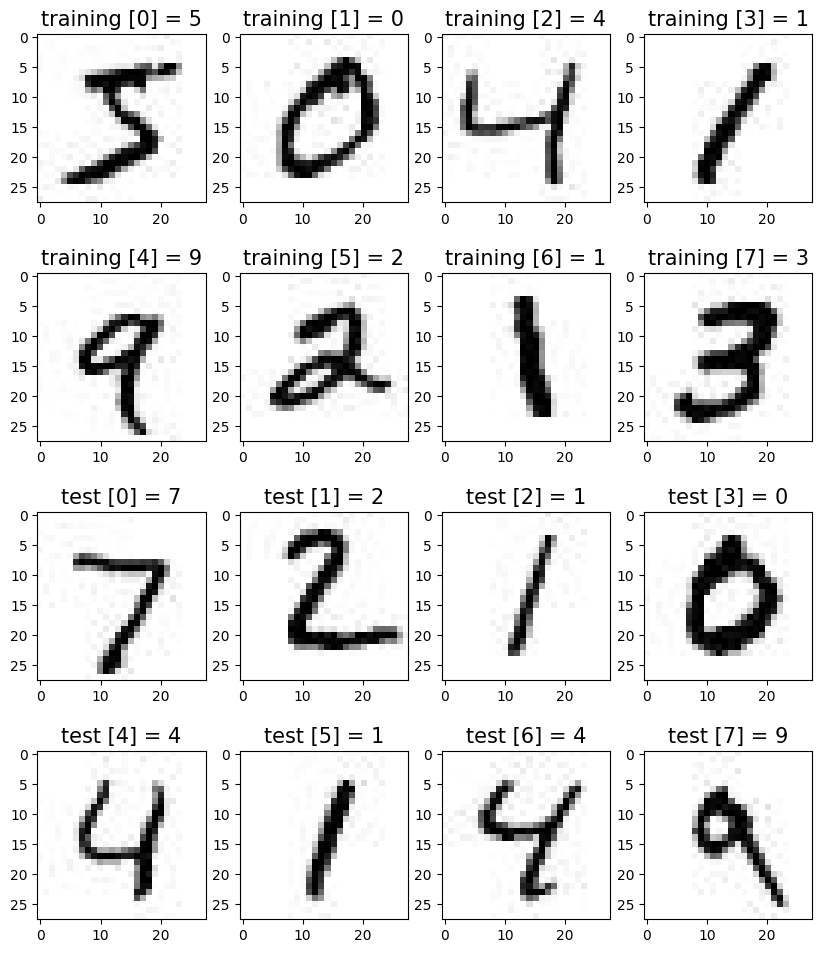

In [13]:
def show_images(images, title_texts):
    cols = 4
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(10,15))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1


x_train, y_train = next(iter(train_set_loader))
x_test, y_test = next(iter(test_set_loader))

#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 8):
    images_2_show.append(x_train[i])
    titles_2_show.append('training [' + str(i) + '] = ' + str(y_train[i].item()))

for i in range(0, 8):
    images_2_show.append(x_test[i])
    titles_2_show.append('test [' + str(i) + '] = ' + str(y_test[i].item()))

show_images(images_2_show, titles_2_show)

# 인공신경망 훈련

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


In [15]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')

print('Current cuda device is', device)

Current cuda device is cuda


In [16]:
class MNIST_MLP(nn.Module):
    def __init__(self):
        super(MNIST_MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        #x = self.fc1_drop(x)
        x = self.fc2(x)
        x = F.relu(x)
        #x = self.fc2_drop(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)



In [17]:
model_mlp = MNIST_MLP().to(device)
optimizer = torch.optim.SGD(model_mlp.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model_mlp)

MNIST_MLP(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc1_drop): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=50, bias=True)
  (fc2_drop): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=50, out_features=10, bias=True)
)


In [18]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model_mlp.state_dict():
    print(param_tensor, "\t", model_mlp.state_dict()[param_tensor].size())
    print(model_mlp.state_dict()[param_tensor])

Model's state_dict:
fc1.weight 	 torch.Size([50, 784])
tensor([[ 0.0348, -0.0057, -0.0113,  ...,  0.0161, -0.0301, -0.0248],
        [ 0.0213, -0.0297,  0.0024,  ..., -0.0179,  0.0065,  0.0213],
        [ 0.0241,  0.0326, -0.0319,  ..., -0.0196, -0.0188,  0.0085],
        ...,
        [ 0.0310, -0.0315,  0.0201,  ...,  0.0312,  0.0215, -0.0021],
        [-0.0105, -0.0035,  0.0178,  ..., -0.0235,  0.0215, -0.0218],
        [ 0.0283, -0.0230, -0.0317,  ..., -0.0077, -0.0242,  0.0130]],
       device='cuda:0')
fc1.bias 	 torch.Size([50])
tensor([ 0.0174, -0.0307,  0.0296, -0.0247,  0.0127, -0.0290, -0.0118, -0.0140,
        -0.0161, -0.0145, -0.0344, -0.0347, -0.0050,  0.0065, -0.0287,  0.0225,
        -0.0040, -0.0052,  0.0112, -0.0223, -0.0140,  0.0241, -0.0019,  0.0269,
        -0.0355, -0.0195,  0.0019, -0.0316, -0.0081,  0.0281,  0.0133,  0.0028,
         0.0125,  0.0252, -0.0196, -0.0053,  0.0062,  0.0124,  0.0177,  0.0348,
         0.0354, -0.0148,  0.0355,  0.0088, -0.0302, -0.016

In [19]:
# 옵티마이저의 state_dict 출력
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.01, 'momentum': 0.5, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5]}]


In [20]:
def train_mnist(_model, _train_set_loader, _device,epoch_num = 1):
  _model.train()
  i = 1
  for epoch in range(epoch_num):
      for data, target in _train_set_loader:
          data = data.to(_device)
          target = target.to(_device)
          optimizer.zero_grad()
          output = _model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          if i % 1000 == 0:
              print("Train Step : {}\tLoss : {:3f}".format(i, loss.item()))
          i += 1

In [21]:
train_mnist(model_mlp,train_set_loader,device,epoch_num = 1)

Train Step : 1000	Loss : 2.236485
Train Step : 2000	Loss : 1.962672
Train Step : 3000	Loss : 1.881282


In [23]:
torch.save(model_mlp.state_dict(), 'model_mlp.save')

# 훈련된 모델 활용 및 평가

In [24]:
model_mlp = MNIST_MLP().to(device)
model_mlp.load_state_dict(torch.load('model_mlp.save'))


<All keys matched successfully>

In [ ]:
# 모델의 state_dict 출력
print("Model's state_dict:")
for param_tensor in model_mlp.state_dict():
    print(param_tensor, "\t", model_mlp.state_dict()[param_tensor].size())
    print(model_mlp.state_dict()[param_tensor])

In [ ]:
model_mlp.eval()
x_test, y_test = next(iter(test_set_loader))

the_num_of_samples = 10

data = x_test[:the_num_of_samples]
data = data.to(device)

predictions = model_mlp(data).detach().cpu().numpy()
print(predictions)
print(np.sum(predictions[0]))
pred_classes = np.argmax(predictions, axis=-1)
print(pred_classes)
correct_preds = np.sum(y_test[:the_num_of_samples].numpy() == pred_classes, axis=0)
train_acc = correct_preds / the_num_of_samples

print('처음 3개 예측: ', pred_classes)
print('훈련 정확도: %.2f%%' % (train_acc * 100))


In [28]:
model_mlp.eval()    # 평가시에는 dropout이 OFF 된다.
correct = 0
for data, target in test_set_loader:
    data = data.to(device)
    target = target.to(device)
    output = model_mlp(data)
    prediction = output.data.max(1)[1]
    correct += prediction.eq(target.data).sum()
print('Test set Accuracy : {:.2f}%'.format(100. * correct / len(test_set_loader.dataset)))

Test set Accuracy : 57.39%


# 모델 예측 결과 시각화

In [29]:
def plot_image(predictions_array, true_label, img):
  #predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  #plt.imshow(img, cmap=plt.cm.binary)
  plt.imshow(img.reshape(28, 28), cmap='Greys')

  predicted_label = np.argmax(predictions_array)
  #print(predicted_label,true_label,np.max(predictions_array),np.sum(predictions_array))
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("pred={}({:2.0f}%), real={}".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)


In [30]:
def plot_value_array(predictions_array, true_label):
  #predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  #plt.yticks([i/10 for i in range(0,11,1)])
  #plt.ylabel('probability')
  #plt.xlabel('class')
  #plt.title('probability')
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


[3.2972875e-06 9.5116270e-08 9.2167744e-07 2.1443188e-05 4.0247432e-06
 5.5386806e-07 6.1310295e-09 9.9890709e-01 4.7352964e-06 1.0578666e-03]


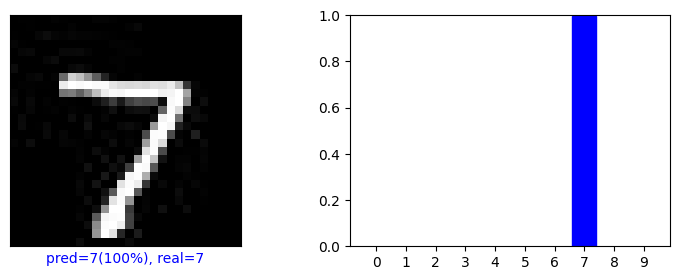

In [31]:
x_test, y_test = next(iter(test_set_loader))

predictions = model_mlp(x_test[0].to(device)).detach().cpu().numpy()[0]
print(predictions)
i = 11
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.subplots_adjust(right=1.3)

plot_image(predictions, y_test[0].item(), x_test[0].detach().cpu().numpy())
plt.subplot(1,2,2)
plot_value_array(predictions,  y_test[0].item())
plt.show()


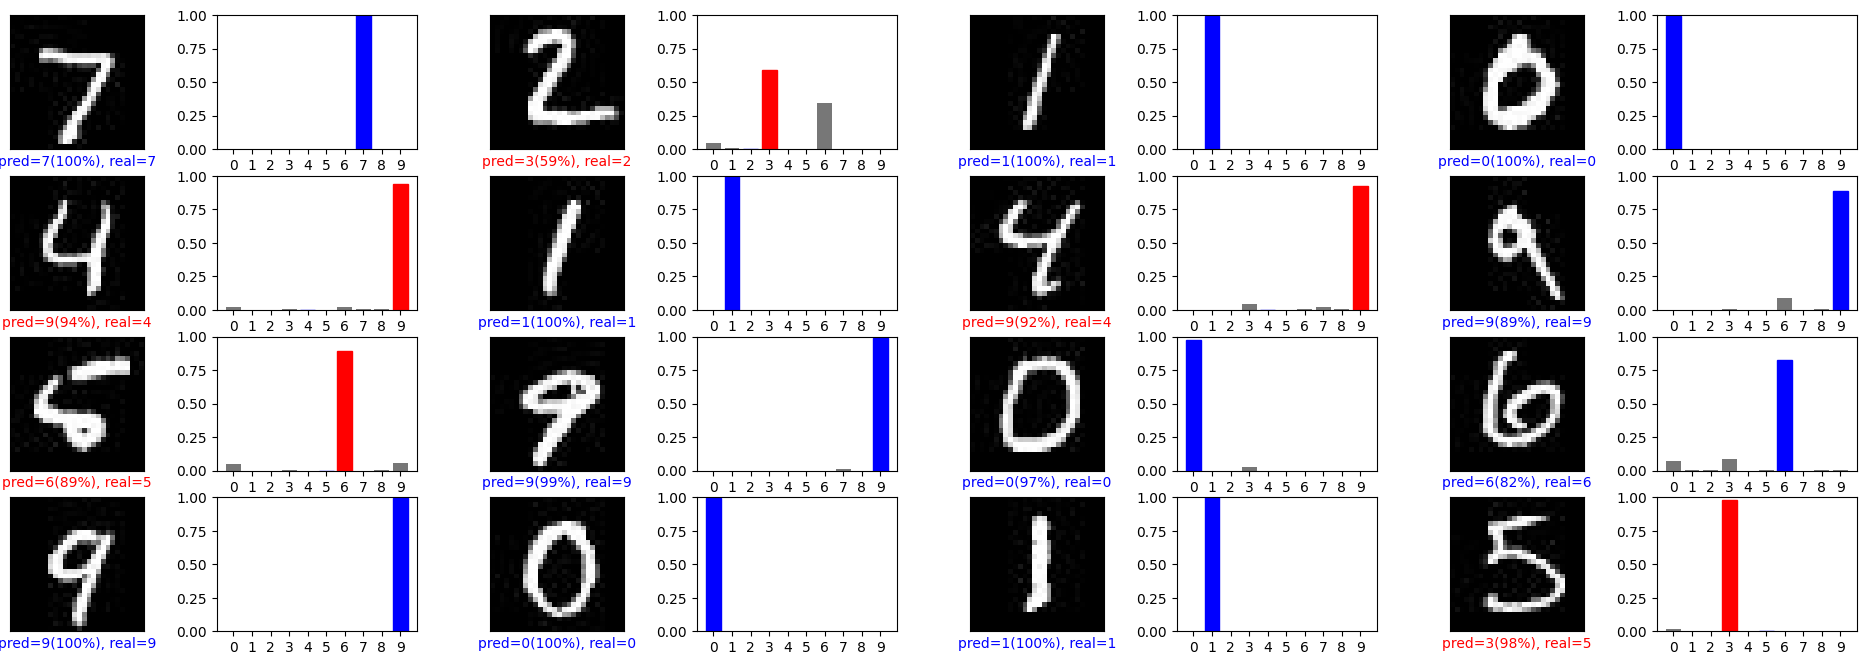

In [32]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

x_test, y_test = next(iter(test_set_loader))

for i in range(len(x_test)):
  img = x_test[i]
  label = y_test[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  predictions = model_mlp(img.to(device)).detach().cpu().numpy()[0]
  plot_image(predictions, label.item(), img.detach().cpu().numpy())
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plt.subplots_adjust(right=1.3)
  plot_value_array(predictions, label.item())
plt.show()


# 그림판으로 만든 이미지 식별

이미지 데이터를 화면에 보기좋게 출력하는 함수

In [ ]:
user_img_file_name = '/content/1.jpg'

In [ ]:
def print_image(sample_image):
  for r in range(0,28):
    for c in range(0,28):
      print("%.2f,"%(sample_image[r,c]),end="")
    print("\n")

user_image = io.imread(user_img_file_name,as_gray=True)
user_image = np.array(user_image).astype(np.float32)
print(user_image.shape)
print_image(user_image)
np.savetxt(fname="user_image.csv", delimiter=",", X=user_image)

(28, 28)
0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,

1.00,0.98,0.99,1.00,1.00,0.98,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,1.00,0.99,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,

0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,1.00,1.00,0.98,1.00,0.99,1.00,1.00,1.00,1.00,1.00,

1.00,1.00,1.00,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,

1.00,1.00,0.98,1.00,1.00,0.98,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.98,1.00,0.98,1.00,1.00,1.00,1.00,0.99,1.00,1.00,1.00,1.00,

1.00,0.99,1.00,0.98,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,1.00,0.99,0.99,1.00,1.00,1.00,1.00,1.00,

1.00,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00

Text(0.5, 1.0, '/content/1.jpg')

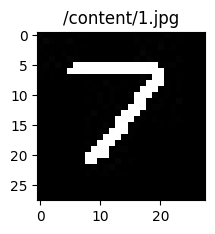

In [ ]:
plt.subplot(223)
plt.imshow(user_image, vmin= 0, vmax=1, cmap='Greys')
plt.title(user_img_file_name)


In [ ]:
test_num = torch.Tensor(user_image.reshape(-1,784))
print(test_num.shape)
predictions = model_mlp(test_num.to(device)).detach().cpu().numpy()[0]
print(predictions)
print(np.argmax(predictions))

x_test, y_test = next(iter(test_set_loader))
predictions = model_mlp(x_test[0].to(device)).detach().cpu().numpy()[0]
print(predictions)
print(np.argmax(predictions))
print(y_test[0].item())

torch.Size([1, 784])
[4.5976049e-06 8.1753725e-01 2.5552290e-04 3.3496276e-02 3.3017283e-04
 9.6277436e-05 3.9722533e-03 1.1460546e-05 1.4416572e-01 1.3048854e-04]
1
[2.7594948e-04 1.5616428e-06 1.5851212e-05 9.6904427e-05 5.9923751e-04
 5.4158231e-06 2.4400773e-09 9.9867874e-01 3.2348424e-04 2.7687472e-06]
7
7


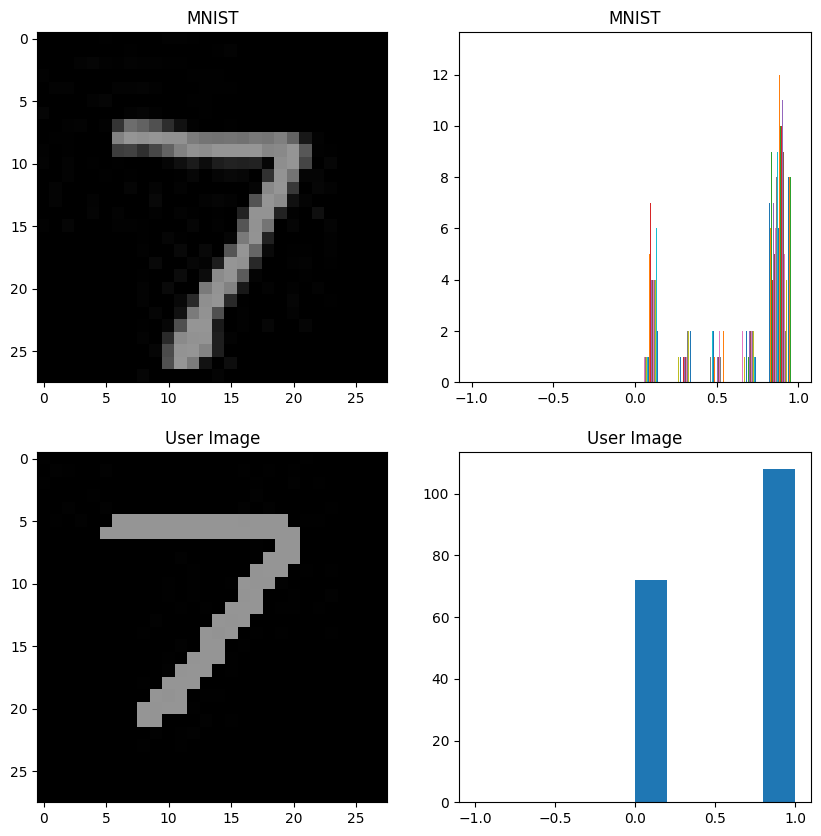

In [ ]:
x_test, y_test = next(iter(test_set_loader))
mnist_img = x_test[0].detach().cpu().numpy()

plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(mnist_img.reshape(28,28), vmin=-1, vmax=1, cmap='Greys')
plt.title("MNIST")


plt.subplot(222)
plt.hist(mnist_img, bins=np.arange(-1, 1.1, 0.2))
plt.title("MNIST")

plt.subplot(223)
plt.imshow(user_image, vmin= -1, vmax=1, cmap='Greys')
plt.title("User Image")



plt.subplot(224)
plt.hist(user_image.flatten(), bins=np.arange(-1, 1.1, 0.2))
plt.title("User Image")
plt.show()


# CNN 기반 인공신경망 모델 학습

In [ ]:
class MNIST_CNN(torch.nn.Module):
  def __init__(self):
    super(MNIST_CNN, self).__init__()
    # 첫번째층
    # ImgIn shape=(?, 28, 28, 1)
    #    Conv     -> (?, 28, 28, 32)
    #    Pool     -> (?, 14, 14, 32)
    self.layer1 = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))

    # 두번째층
    # ImgIn shape=(?, 14, 14, 32)
    #    Conv      ->(?, 14, 14, 64)
    #    Pool      ->(?, 7, 7, 64)
    self.layer2 = torch.nn.Sequential(
        torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=2, stride=2))

    # 전결합층 7x7x64 inputs -> 10 outputs
    self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)

    # 전결합층 한정으로 가중치 초기화
    torch.nn.init.xavier_uniform_(self.fc.weight)

  def forward(self, x):
    x = x.reshape(-1,1,28,28)
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)   # 전결합층을 위해서 Flatten
    out = self.fc(out)
    return out
model_cnn = MNIST_CNN().to(device)
optimizer = torch.optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model_cnn)

MNIST_CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)


In [ ]:
train_mnist(model_cnn,train_set_loader,device,epoch_num = 1)

Train Step : 1000	Loss : 0.506165
Train Step : 2000	Loss : 0.074975
Train Step : 3000	Loss : 0.066822


In [ ]:
torch.save(model_cnn.state_dict(), 'model_cnn.save')

In [ ]:
model_cnn = MNIST_CNN().to(device)
model_cnn.load_state_dict(torch.load('model_cnn.save'))

<All keys matched successfully>

In [ ]:
test_num = torch.Tensor(user_image.reshape(-1,784))
print(test_num.shape)
predictions = model_cnn(test_num.to(device)).detach().cpu().numpy()[0]
print(predictions)
print(np.argmax(predictions))

x_test, y_test = next(iter(test_set_loader))
predictions = model_cnn(x_test[0].to(device)).detach().cpu().numpy()[0]
print(predictions)
print(np.argmax(predictions))
print(y_test[0].item())

torch.Size([1, 784])
[-2.995943    3.025658    6.8146734   5.14793    -5.7373166  -5.987685
 -8.873726    4.2247043   2.8262455   0.02091818]
2
[ -0.84809875  -2.341737     2.0785584    3.02827     -4.592793
  -0.6447896  -11.455406    14.055748    -2.0949922    4.959429  ]
7
7


# 웹배포

In [33]:
from google.colab.output import eval_js
print(eval_js("google.colab.kernel.proxyPort(5000)"))

https://k9x0il3m8r-496ff2e9c6d22116-5000-colab.googleusercontent.com/


In [48]:
from flask import Flask, render_template, request
app = Flask(__name__, template_folder='/content/templates')
@app.route("/")
def home():
    print(app.root_path)
    return render_template('index.html')
@app.route('/predict',methods = ['POST', 'GET'])
def predict():
  if request.method == 'POST':
    file = request.files['file']
    # if user does not select file, browser also
    # submit a empty part without filename
    if file.filename == '':
        flash('No selected file')
        return redirect(request.url)
    user_img_file_name = os.path.join("/content", file.filename)
    file.save(user_img_file_name)




    user_image = io.imread(user_img_file_name,as_gray=True)
    user_image = np.array(user_image).astype(np.float32)

    plt.imshow(user_image, vmin= 0, vmax=1, cmap='Greys')

    test_num = torch.Tensor(user_image.reshape(-1,784))
    predictions = model_mlp(test_num.to(device)).detach().cpu().numpy()[0]
    print(predictions)
    pred_class = np.argmax(predictions)
    print(pred_class)
    return render_template("pred.html", predicted_class=pred_class, img_src=user_img_file_name, score=str(predictions[pred_class]*100))

if __name__ == "__main__":
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [10/Oct/2023 18:31:14] "GET / HTTP/1.1" 200 -


/content


INFO:werkzeug:127.0.0.1 - - [10/Oct/2023 18:31:14] "GET /favicon.ico HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [10/Oct/2023 18:31:32] "GET /user.jpg HTTP/1.1" 404 -
INFO:werkzeug:127.0.0.1 - - [10/Oct/2023 18:31:33] "GET /user.jpg HTTP/1.1" 404 -
